# Linkedin, AnchorFM follower analysis

> **Goal**
>
> Have one dashboard to summarizes SAI's reach across platforms. 
> KPI is **Total unique visitors per week**.



## Purpose of this notebook

Explore ways to merge social media data across platforms. Make **daily** follower statistics from `linkedin` and `anchorfm` (manually) accessible. Focus on the **total sum**, such as **Total page views** or **Total plays**.

### Implementation

1. load files from directory, where the raw data lives (e.g. `../data/raw`)
3. create a common `date` column with datetime format *UTC*
4. drop date duplicates
4. transform into long format which yields:
    |   |                      date | platform | variable | value |
    |--:|--------------------------:|---------:|---------:|------:|
    | 0 | 2020-10-08 00:00:00+00:00 |   anchor |    Plays |   0.0 |
    | 1 | 2020-10-09 00:00:00+00:00 |   anchor |    Plays |   0.0 |
    | 2 | 2020-10-10 00:00:00+00:00 |   anchor |    Plays |   0.0 |
4. export as csv  (e.g. `../data/processed`)


In [54]:
%%writefile ../src/data/process_data.py

import pandas as pd
from glob import glob
from os import path

def load_files(data_dir, filename):
    # get all files from ../data/raw folder (linkedin as xls, anchor as csv)
    # use path.join since it's OS agnostic, flatten list
    list_files = [i for sublist in [glob(path.join(data_dir, f"{t}*")) for t in filename.values()] for i in sublist] 
    
    print(list_files)
    # need to select each platform since LinkedIn uses .xls format
    anchor_files = [i for i in list_files if filename['anchor'] in i]
    linkedin_files = [i for i in list_files if filename['linkedin'] in i]
    twitter_files = [i for i in list_files if filename['twitter'] in i]

    # print selected files
    print("LOAD FILES\n"+'-'*42)
    print("Anchor\n"+'-'*10, *anchor_files, sep='\n')
    print("LinkedIn\n"+'-'*10, *linkedin_files, sep='\n')
    print("Twitter\n"+'-'*10, *twitter_files, sep='\n')
    
    # load data
    df_anchor = pd.concat([pd.read_csv(file) for file in anchor_files], axis=0)
    df_linkedin = pd.concat([pd.read_excel(file) for file in linkedin_files], axis=0)
    df_twitter = pd.concat([pd.read_csv(file) for file in twitter_files], axis=0)
    
    return df_anchor, df_linkedin, df_twitter

def add_columns(df_anchor, df_linkedin, df_twitter):
    print("\nAdd relevant columns\n"+'-'*30)

    # create date column with datetime format from original timestamp
    # bug fix: anchor reported 24:00:00 as time instead of 00:00:00 
    # --> replace strings to parse date
    if df_anchor['Time (UTC)'].str.contains("24:").any():
        df_anchor['Time (UTC)'] = df_anchor['Time (UTC)'].str.replace("24:", "00:")
        
    df_anchor['date'] = pd.to_datetime(df_anchor['Time (UTC)'], utc=True)
    df_linkedin['date'] = pd.to_datetime(df_linkedin['Date'], utc=True)
    df_twitter['date'] = pd.to_datetime(df_twitter['Date'], utc=True)

    # create variable indicating platform
    df_anchor['platform'] = 'anchor'
    df_linkedin['platform'] = 'linkedin'
    df_twitter['platform'] = 'twitter'
    
    # define total view column
    df_anchor['total_views'] = df_anchor['Plays']
    df_linkedin['total_views'] = df_linkedin['Total page views (total)']
    df_twitter['total_views'] = df_twitter['impressions']
    
    # drop duplicates on date
    df_anchor.drop_duplicates(subset=['date'], inplace=True)
    df_linkedin.drop_duplicates(subset=['date'], inplace=True)
    df_twitter.drop_duplicates(subset=['date'], inplace=True)
    
    print("\nadded date and platform column\n"+'-'*10)
    
    return df_anchor, df_linkedin, df_twitter

def merge(df_anchor, df_linkedin, df_twitter, select_columns=['date', 'platform', 'total_views']):
    """ Merge dataframes, keep selected columns """
    
    print("\nMERGE\n"+'-'*30)

    # merge anchor and linkedin data on date
    df_all_vars = df_anchor.merge(df_linkedin, how='outer')\
                            .merge(df_twitter, how='outer')

    select_columns=['date', 'platform', 'total_views']
    # select relevant columns, drop duplicates, fill NaNs, sort
    df_clean = df_all_vars[select_columns]\
                .drop_duplicates()\
                .fillna(0)\
                .sort_values('date')
    # create long format
    df = df_clean.melt(id_vars=['date', 'platform'])
    
    return df

def export(df, data_dir, filename='social_media_long.csv'):
    
    print(f"Export dataframe of dimensions {df.shape}")
    
    # export data
    df.to_csv(path.join(data_dir, filename), index=False)
    
    print("\nSUCCESS\n"+'='*42)
    

def main():
    ###### CONFIG #######
    raw_data_dir = '../data/raw/'
    processed_data_dir = '../data/processed/'
    filename = {
        'anchor': 'RWYToSustainability', 
        'linkedin':'sustainableaviationinitiative_visitors', 
        'twitter': 'daily_tweet_activity_metrics'
        }
    #####################
    
    df_anchor, df_linkedin, df_twitter = load_files(data_dir=raw_data_dir, filename=filename)
    df_anchor, df_linkedin, df_twitter = add_columns(df_anchor, df_linkedin, df_twitter)
    df = merge(df_anchor, df_linkedin, df_twitter)
    export(df, processed_data_dir)
    
if __name__ == '__main__':
    main()

Overwriting ../src/data/process_data.py


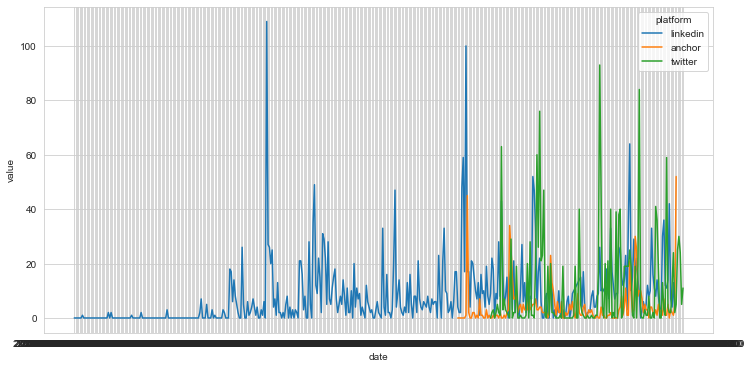

In [53]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')

df = pd.read_csv('../data/processed/social_media_long.csv')

a4_dims = (12, 6)
fig, ax = plt.subplots(figsize=a4_dims)

fig = sns.lineplot(data=df, x='date', y='value', hue='platform')
plt.show()